# **1. Load libraries**

In [51]:
# Data manipulation
#==============================================================
import pandas as pd
import numpy as np

# Data visualization
#==============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Preprocessing
#=============================================================
from sklearn.model_selection import train_test_split

# Torch
#=============================================================
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Metrics
#====================================================================
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# os
#==========================
import os

# Path
#=====================================
from pathlib import Path

# random
#======================================
import random

# tqdm
#========================================
from tqdm.auto import tqdm

# warnings
#=======================================
import warnings
warnings.filterwarnings("ignore")

# **2. Load data**

In [2]:
IMAGE_PATH = Path("/kaggle/input/eggs-images-classification-damaged-or-not/Eggs Classification")
IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*.jpg"))

print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 794


In [3]:
LABELS = sorted(os.listdir(IMAGE_PATH), reverse = True)
LABELS

['Not Damaged', 'Damaged']

In [4]:
for label in LABELS:
    total_images_label = list(Path(os.path.join(IMAGE_PATH, label)).glob("*.jpg"))
    print(f'* {label}: {len(total_images_label)} images')

* Not Damaged: 162 images
* Damaged: 632 images


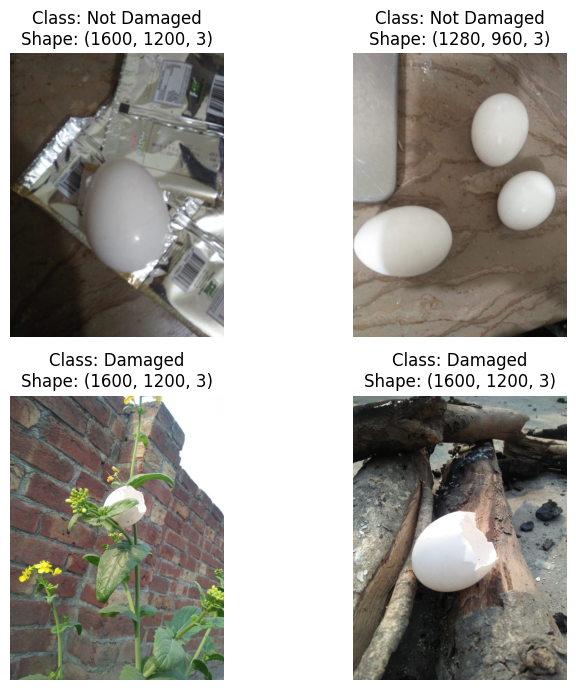

In [5]:
NUM_IMAGES = 2

fig,axs = plt.subplots(nrows = len(LABELS), ncols = NUM_IMAGES, figsize = (8,7))
p = 0

for label in LABELS:
    total_images_label = list(Path(os.path.join(IMAGE_PATH, label)).glob("*.jpg"))
    total_selected = random.choices(total_images_label, k = NUM_IMAGES)
    
    for i,img_path in enumerate(total_selected):
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        axs[p,i].imshow(img_rgb)
        axs[p,i].set_title(f'Class: {label}\nShape: {img_rgb.shape}')
        axs[p,i].axis('off')
        
    p += 1
    
fig.tight_layout()
fig.show()

# **3. Preprocessing**

In [6]:
target = [image_path.parent.stem for image_path in IMAGE_PATH_LIST]

data = pd.DataFrame({'Image':IMAGE_PATH_LIST, 'Target':target})
data.head()

,Image,Target
0,/kaggle/input/eggs-images-classification-damag...,Damaged
1,/kaggle/input/eggs-images-classification-damag...,Damaged
2,/kaggle/input/eggs-images-classification-damag...,Damaged
3,/kaggle/input/eggs-images-classification-damag...,Damaged
4,/kaggle/input/eggs-images-classification-damag...,Damaged


In [7]:
SEED = 1234

data_train, data_rest = train_test_split(data, test_size = 0.3, random_state = SEED)

data_val, data_test = train_test_split(data_rest, test_size = 0.5, random_state = SEED)

In [8]:
data_train['Target'].value_counts()

Target
Damaged        434
Not Damaged    121
Name: count, dtype: int64

In [9]:
data_val['Target'].value_counts()

Target
Damaged        96
Not Damaged    23
Name: count, dtype: int64

In [10]:
data_test['Target'].value_counts()

Target
Damaged        102
Not Damaged     18
Name: count, dtype: int64

In [11]:
label2id = dict(zip(LABELS, range(len(LABELS))))
label2id

{'Not Damaged': 0, 'Damaged': 1}

In [12]:
weights = EfficientNet_B0_Weights.DEFAULT
image_transforms = weights.transforms()
image_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

- **Dataset**

In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, data:pd.DataFrame, label2id:dict, transforms = None):
        self.data = data
        self.label2id = label2id
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data_new = self.data.copy()
        data_new['Target'] = data_new['Target'].map(self.label2id)
        
        image_path = data_new.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        target = data_new.iloc[idx, 1]
        
        return image, target

In [14]:
train_dataset = CustomImageDataset(data_train, label2id, image_transforms)
val_dataset = CustomImageDataset(data_val, label2id, image_transforms)

- **DataLoader**

In [15]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

val_dataloader = DataLoader(dataset = val_dataset, 
                            batch_size = BATCH_SIZE, 
                            shuffle = True, 
                            num_workers = NUM_WORKERS)

In [16]:
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

# **4. Model**

In [17]:
# GPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [18]:
# Define model
model = efficientnet_b0(weights = weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 126MB/s] 


In [19]:
summary(model = model, 
        input_size = [32, 3, 224, 224], 
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width = 15, 
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 1000]      --              True
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] --              True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --              True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] 864             True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] 64              True
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --              --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --              True
│    │    └─MBConv (0)                              

In [20]:
for param in model.features.parameters():
    param.requires_grad = False

In [21]:
summary(model = model, 
        input_size = [32, 3, 224, 224], 
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width = 15, 
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 1000]      --              Partial
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] --              False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --              False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] (864)           False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] (64)            False
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --              --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --              False
│    │    └─MBConv (0)                      

In [22]:
model.classifier = nn.Sequential(nn.Dropout(p = 0.2), 
                                 nn.Linear(in_features = 1280, out_features = 1))

In [23]:
summary(model = model, 
        input_size = [32, 3, 224, 224], 
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width = 15, 
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 1]         --              Partial
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] --              False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --              False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] (864)           False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] (64)            False
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --              --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --              False
│    │    └─MBConv (0)                      

In [24]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [25]:
predict_logit = model(batch_images.to(DEVICE))
predict_logit.shape

torch.Size([32, 1])

In [26]:
class EarlyStopping:
    def __init__(self, patience:int = 10, delta:float = 0.00001, path = "best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        
    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
            
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            
            
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)
                

In [27]:
early_stopping = EarlyStopping(patience = 10, delta = 0.)

In [32]:
def train_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer):
    
    model.train()
    
    train_loss = 0
    train_accuracy = 0
    
    for batch,(X,y) in enumerate(dataloader):
        X = X.to(device = DEVICE, dtype = torch.float32)
        y = y.to(device = DEVICE, dtype = torch.float32)
        
        optimizer.zero_grad()
        
        y_pred_logit = model(X)
        loss = loss_fn(y_pred_logit.squeeze(), y)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        y_pred_prob = y_pred_logit.squeeze().sigmoid()
        y_pred_target = (y_pred_prob > 0.5).float()
        
        train_accuracy += balanced_accuracy_score(y.cpu().numpy(), 
                                                  y_pred_target.detach().cpu().numpy())
        
    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(dataloader)
    
    return train_loss, train_accuracy
        

In [36]:
def val_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
             loss_fn:torch.nn.Module):
    
    model.eval()
    
    val_loss = 0
    val_accuracy = 0
    
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            y = y.to(device = DEVICE, dtype = torch.float32)

            y_pred_logit = model(X)
            loss = loss_fn(y_pred_logit.squeeze(), y)
            val_loss += loss.item()

            y_pred_prob = y_pred_logit.squeeze().sigmoid()
            y_pred_target = (y_pred_prob > 0.5).float()

            val_accuracy += balanced_accuracy_score(y.cpu().numpy(), 
                                                      y_pred_target.detach().cpu().numpy())
        
    val_loss = val_loss / len(dataloader)
    val_accuracy = val_accuracy / len(dataloader)
    
    return val_loss, val_accuracy

In [37]:
def train(model:torch.nn.Module, train_dataloader:torch.utils.data.DataLoader, 
          val_dataloader:torch.utils.data.DataLoader, loss_fn:torch.nn.Module, 
          optimizer:torch.optim.Optimizer, early_stopping, epochs:int = 10):
    
    results = {'train_loss':[], 
               'train_accuracy':[], 
               'val_loss':[], 
               'val_accuracy':[]}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model, 
                                                dataloader = train_dataloader, 
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
        
        val_loss, val_accuracy = val_step(model = model, 
                                          dataloader = val_dataloader, 
                                          loss_fn = loss_fn)
        
        print(f'Epoch:{epoch + 1} |', 
              f'Train Loss:{train_loss:.4f} |', 
              f'Train Accuracy:{train_accuracy:.4f} |', 
              f'Val Loss:{val_loss:.4f} |', 
              f'Val Accuracy:{val_accuracy:.4f}')
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop == True:
            print("Early Stopping!!!")
            break
            
        results['train_loss'].append(train_loss)
        results['train_accuracy'].append(train_accuracy)
        results['val_loss'].append(val_loss)
        results['val_accuracy'].append(val_accuracy)
        
    return results

In [38]:
EPOCHS = 100
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

RESULTS = train(model.to(device = DEVICE), 
                train_dataloader, 
                val_dataloader, 
                loss_fn, 
                optimizer, 
                early_stopping, 
                EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:1 | Train Loss:0.3833 | Train Accuracy:0.5394 | Val Loss:0.2905 | Val Accuracy:0.6278
Epoch:2 | Train Loss:0.3361 | Train Accuracy:0.6526 | Val Loss:0.2579 | Val Accuracy:0.7311
Epoch:3 | Train Loss:0.2876 | Train Accuracy:0.7125 | Val Loss:0.2228 | Val Accuracy:0.8724
Epoch:4 | Train Loss:0.2653 | Train Accuracy:0.7800 | Val Loss:0.2075 | Val Accuracy:0.9047
Epoch:5 | Train Loss:0.2438 | Train Accuracy:0.8309 | Val Loss:0.1790 | Val Accuracy:0.9571
Epoch:6 | Train Loss:0.2118 | Train Accuracy:0.8823 | Val Loss:0.1690 | Val Accuracy:0.9732
Epoch:7 | Train Loss:0.1979 | Train Accuracy:0.8845 | Val Loss:0.1472 | Val Accuracy:0.9764
Epoch:8 | Train Loss:0.1834 | Train Accuracy:0.9005 | Val Loss:0.1359 | Val Accuracy:0.9753
Epoch:9 | Train Loss:0.1920 | Train Accuracy:0.9052 | Val Loss:0.1350 | Val Accuracy:0.9729
Epoch:10 | Train Loss:0.1768 | Train Accuracy:0.9136 | Val Loss:0.1296 | Val Accuracy:0.9804
Epoch:11 | Train Loss:0.1679 | Train Accuracy:0.9281 | Val Loss:0.1198 | Val Ac

In [39]:
# We define a function to visualize the evolution of the loss and the metric.
def loss_and_metric_plot(results:dict):
    
    plt.style.use('ggplot')
    training_loss = results['train_loss']
    training_metric = results['train_accuracy']
    
    validation_loss = results['val_loss']
    validation_metric = results['val_accuracy']
    
    fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,3.8))
    ax = ax.flat
    
    ax[0].plot(training_loss, label = "Train")
    ax[0].plot(validation_loss, label = "Val")
    ax[0].set_title("BinaryCrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    ax[0].set_xlabel("Epoch", fontsize = 10, fontweight = "bold", color = "black")
    ax[0].set_ylabel("loss", fontsize = 10, fontweight = "bold", color = "black")
    
    ax[1].plot(training_metric, label = "Train")
    ax[1].plot(validation_metric, label = "Val")
    ax[1].set_title("Balanced Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    ax[1].set_xlabel("Epoch", fontsize = 10, fontweight = "bold", color = "black")
    ax[1].set_ylabel("score", fontsize = 10, fontweight = "bold", color = "black")
    
    ax[0].legend()
    ax[1].legend()
    fig.tight_layout()
    fig.show()

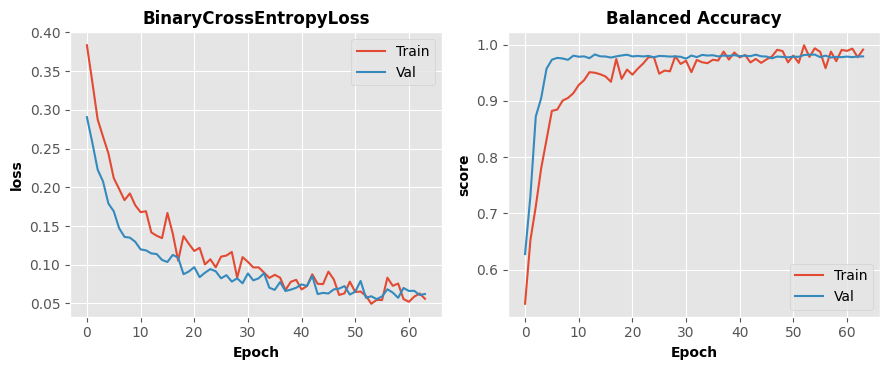

In [40]:
loss_and_metric_plot(RESULTS)

# **5. Predictions**

In [41]:
def predictions(test_dataloader:torch.utils.data.DataLoader):
    
    checkpoint = torch.load("best_model.pth")
    
    loaded_model = efficientnet_b0()
    
    loaded_model.classifier = nn.Sequential(nn.Dropout(p = 0.2), 
                                 nn.Linear(in_features = 1280, out_features = 1))
    
    loaded_model.load_state_dict(checkpoint)
    
    loaded_model.to(device = DEVICE)
    
    loaded_model.eval()
    
    y_pred_test = []
    
    with torch.inference_mode():
        for X,_ in tqdm(test_dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            y_pred_logit = loaded_model(X)
            y_pred_prob = y_pred_logit.squeeze().sigmoid()
            y_pred_target = (y_pred_prob > 0.5).float()
            y_pred_test.append(y_pred_target.detach().cpu())
            
    y_pred_test = torch.cat(y_pred_test)
    
    return y_pred_test

In [42]:
# We create our Test Dataset and Test DataLoader.
test_dataset = CustomImageDataset(data_test, label2id, image_transforms)

test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, 
                             shuffle = False, num_workers = NUM_WORKERS)

In [43]:
# We make the predictions.
y_pred_test = predictions(test_dataloader)

  0%|          | 0/4 [00:00<?, ?it/s]

- **Balanced Accuracy**

In [44]:
test_bal_accuracy = balanced_accuracy_score(data_test['Target'].map(label2id), y_pred_test.numpy())

print(f"Balanced Accuracy Test = {test_bal_accuracy:.4f}")

Balanced Accuracy Test = 0.9248


- **Confusion Matrix**

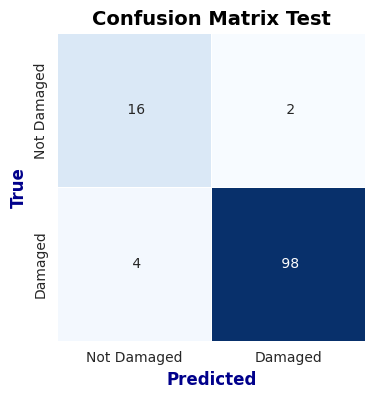

In [46]:
cf_mx_test = confusion_matrix(data_test['Target'].map(label2id), y_pred_test.numpy())

fig,ax = plt.subplots(figsize = (6,4))
sns.set_style('dark')
sns.heatmap(cf_mx_test, cmap = 'Blues', fmt = ' ', annot = True, cbar = False, square = True, linewidths = 0.4,
            xticklabels = LABELS, yticklabels = LABELS, ax = ax)
ax.set_ylabel("True", color = "darkblue", fontsize = 12, fontweight = "bold")
ax.set_xlabel("Predicted", color = "darkblue", fontsize = 12, fontweight = "bold")
ax.set_title("Confusion Matrix Test", fontsize = 14, fontweight = "bold", color = "black")

fig.show()

- **Classification Report**

In [50]:
print(classification_report(data_test['Target'].map(label2id), y_pred_test.numpy(), target_names = LABELS))

              precision    recall  f1-score   support

 Not Damaged       0.80      0.89      0.84        18
     Damaged       0.98      0.96      0.97       102

    accuracy                           0.95       120
   macro avg       0.89      0.92      0.91       120
weighted avg       0.95      0.95      0.95       120

